In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

c:\Users\jaesc2\GitHub\skforecast


SOURCES:

https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html

https://medium.com/@icvandenende/leveraging-conformal-prediction-in-python-to-accelerate-the-renewable-energy-transition-09b5c855f69d

https://mindfulmodeler.substack.com/p/week-3-conformal-prediction-for-regression



In [48]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)

# Modelling and Forecasting
# ==============================================================================
import skforecast
import sklearn
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_pinball_loss
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, OneStepAheadFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import coverage

# Warnings configuration
# ==============================================================================
import warnings
from skforecast.exceptions import OneStepAheadValidationWarning
warnings.filterwarnings('once')

print('Versión skforecast:', skforecast.__version__)
print('Versión sklearn:', sklearn.__version__)

Versión skforecast: 0.15.0
Versión sklearn: 1.5.2


In [3]:
# Load data
# ==============================================================================
data = pd.read_csv("https://raw.githubusercontent.com/skforecast/skforecast-datasets/main/data/ETTm2.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.asfreq('15min')
data = data.resample(rule="1h", closed="left", label="right").mean()
data.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.55100,4.12575,1.26050,37.838250
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.13700,3.59025,0.62900,36.849250
2016-07-01 03:00:00,38.240000,11.41350,35.343501,9.10725,3.06000,0.31175,35.915750
2016-07-01 04:00:00,37.800250,11.45525,34.881000,9.28850,3.04400,0.60750,32.839375
2016-07-01 05:00:00,36.501750,10.49200,33.708250,8.65150,2.64400,0.00000,31.466125


In [5]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )

exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['OT']).tolist()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.55100,4.12575,1.26050,37.83825,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.258819,0.965926
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.13700,3.59025,0.62900,36.84925,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.500000,0.866025
2016-07-01 03:00:00,38.240000,11.41350,35.343501,9.10725,3.06000,0.31175,35.91575,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.707107,0.707107


In [6]:
selected_exog = [
    "HUFL",
    "HULL",
    "LUFL",
    "LULL",
    "MUFL",
    "MULL",
    "day_of_week_sin",
    "hour_cos",
    "hour_sin",
    "month_cos",
    "month_sin",
    "week_cos",
    "week_sin",
    "year",
]

lags = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 42]

In [7]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-08-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2017-08-01 23:00:00  (n=9527)
Dates validacion : 2017-08-02 00:00:00 --- 2018-04-03 23:00:00  (n=5880)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 20:00:00  (n=2013)


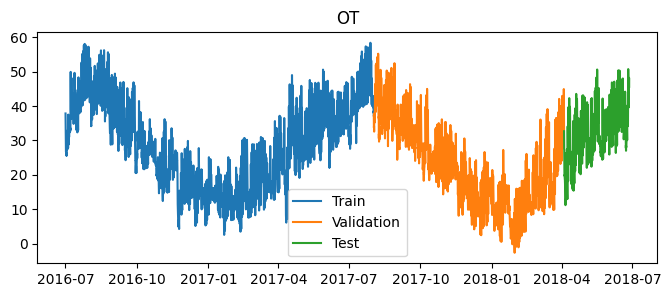

In [8]:
# Plot partitions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

# Quantile regression with ForecasterDirect

In [8]:
# Create forecasters: one for each limit of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_lower_bound = ForecasterDirect(
                            regressor = LGBMRegressor(
                                            objective    = 'quantile',
                                            metric       = 'quantile',
                                            alpha        = 0.1,
                                            random_state = 15926,
                                            verbose      = -1
                                            
                                        ),
                            lags  = lags,
                            steps = 24,
                            differentiation = 1,
                        )
# Forecaster for quantile 90%
forecaster_upper_bound = ForecasterDirect(
                            regressor = LGBMRegressor(
                                            objective    = 'quantile',
                                            metric       = 'quantile',
                                            alpha        = 0.9,
                                            random_state = 15926,
                                            verbose      = -1
                                            
                                        ),
                            lags  = lags,
                            steps = 24,
                            differentiation = 1,
                        )

In [9]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_constructor(alpha: float) -> callable:
    """
    Create Pinball loss for a given quantile.

    Parameters
    ----------
    alpha: float
        Quantile.

    Returns
    -------
    mean_pinball_loss_q: callable
        Mean Pinball loss for the given quantile.
    """
    if not (0 <= alpha <= 1):
        raise ValueError("alpha must be between 0 and 1.")

    def mean_pinball_loss_q(y_true, y_pred):
        return mean_pinball_loss(y_true, y_pred, alpha=alpha)
    return mean_pinball_loss_q

mean_pinball_loss_q05 = mean_pinball_loss_constructor(alpha=0.05)
mean_pinball_loss_q10 = mean_pinball_loss_constructor(alpha=0.1)
mean_pinball_loss_q90 = mean_pinball_loss_constructor(alpha=0.9)
mean_pinball_loss_q95 = mean_pinball_loss_constructor(alpha=0.95)

In [10]:
# Bayesian search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth'     : trial.suggest_categorical('max_depth', [-1, 3, 5, 7, 10]),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1)
    }

    return search_space

cv = OneStepAheadFold(
        initial_train_size = len(data.loc[:end_train, :]),
        differentiation    = 1,
     )

warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
results_grid_lower_bound = bayesian_search_forecaster(
                       forecaster     = forecaster_lower_bound,
                       y              = data.loc[:end_validation, 'OT'],
                       exog           = data.loc[:end_validation, selected_exog],
                       cv             = cv,
                       metric         = mean_pinball_loss_q10,
                       search_space   = search_space,
                       n_trials       = 10,
                       random_state   = 123,
                       return_best    = True,
                       n_jobs         = 'auto',
                       verbose        = False,
                       show_progress  = True
                   )
warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)
results_grid_upper_bound = bayesian_search_forecaster(
                       forecaster    = forecaster_upper_bound,
                       y              = data.loc[:end_validation, 'OT'],
                       exog           = data.loc[:end_validation, selected_exog],
                       cv            = cv,
                       metric        = mean_pinball_loss_q90,
                       search_space  = search_space,
                       n_trials      = 10,
                       random_state  = 123,
                       return_best   = True,
                       n_jobs        = 'auto',
                       verbose       = False,
                       show_progress = True
                   )

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 42] 
  Parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.0982687778546154}
  One-step-ahead metric: 113.41750122415243


  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 42] 
  Parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.0982687778546154}
  One-step-ahead metric: 118.88555526782139


## Conformal intervals

In [14]:
# 1) Backtesting on your calibration set (validacion)
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_train, :]),
        steps              = 24,  # all hours of next day
        differentiation    = 1
     )
_, predictions_lower_bound = backtesting_forecaster(
                                  forecaster          = forecaster_lower_bound,
                                  y                   = data.loc[:end_validation, 'OT'],
                                  exog                = data.loc[:end_validation, selected_exog],
                                  cv                  = cv,
                                  metric              = mean_pinball_loss_q05,
                                  n_jobs              = 'auto',
                                  verbose             = False,
                                  show_progress       = True
                              )

_, predictions_upper_bound = backtesting_forecaster(
                                  forecaster          = forecaster_upper_bound,
                                  y                   = data.loc[:end_validation, 'OT'],
                                  exog                = data.loc[:end_validation, selected_exog],
                                  cv                  = cv,
                                  metric              = mean_pinball_loss_q05,
                                  n_jobs              = 'auto',
                                  verbose             = False,
                                  show_progress       = True
                              )
prediction_interval_calibration = pd.concat([predictions_lower_bound, predictions_upper_bound], axis=1)
prediction_interval_calibration.columns = ['lower_bound', 'upper_bound']
prediction_interval_calibration['y_true'] = data.loc[end_train:end_validation, 'OT']
prediction_interval_calibration.head(3)


  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

,lower_bound,upper_bound,y_true
2017-08-02 00:00:00,36.778605,37.297546,37.124001
2017-08-02 01:00:00,36.202903,37.946289,37.014250
2017-08-02 02:00:00,35.596580,38.055787,35.970376


Conformity score in Conformalized quantile regression:

$$s(y,x) == max(\hat{q}_{low}(X) - y_{true}, y_{true} - \hat{q}_{up}(X))$$

The score is positive if the true y value lies outside of the interval, and negative if it lies inside.

The threshold q can be interpreted as the term by which the interval has to be expanded (on both ends) or shortened. If 1-ɑ of the y’s are already within the interval (meaning the model is well calibrated), then the threshold would be at 0. A positive threshold means that the original intervals were too narrow, and a negative one that quantile intervals were too wide.

To compute the prediction interval, we add the threshold to the upper bound and subtract it from the lower bound (aka the old quantiles).

The calibration part of the procedure is not adaptive, since the same term will be added no matter the feature values. However, the entire procedure is adaptive since quantile regression is adaptive.

In [ ]:
# 2) Non-conformity score
# ==============================================================================
y_true = data.loc[end_train:end_validation, 'OT']
conformity_scores = np.max(
    [
        prediction_interval_calibration['lower_bound'] - y_true,
        y_true - prediction_interval_calibration['upper_bound'],
    ],
    axis=0,
)
conformity_scores

array([ -0.17354542,  -0.81134709,  -0.37379557, ..., -12.19030303,
       -13.82318163, -14.649602  ])

In [ ]:
# 3) Correction factor
# ==============================================================================
nominal_coverage = 0.8
correction_factor = np.quantile(conformity_scores, nominal_coverage)
correction_factor

-0.29663300635844236

In [17]:
# 4) Backtesting on test data
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_validation, :]),
        steps              = 24,  # all hours of next day
        differentiation    = 1
     )
_, predictions_lower_bound = backtesting_forecaster(
                                 forecaster          = forecaster_lower_bound,
                                 y                   = data['OT'],
                                 exog                = data[selected_exog],
                                 cv                  = cv,
                                 metric              = mean_pinball_loss_q10,
                                 n_jobs              = 'auto',
                                 verbose             = False,
                                 show_progress       = True
                              )

_, predictions_upper_bound = backtesting_forecaster(
                                  forecaster          = forecaster_upper_bound,
                                  y                   = data['OT'],
                                  exog                = data[selected_exog],
                                  cv                  = cv,
                                  metric              = mean_pinball_loss_q90,
                                  n_jobs              = 'auto',
                                  verbose             = False,
                                  show_progress       = True
                              )

prediction_interval_test = pd.concat([predictions_lower_bound, predictions_upper_bound], axis=1)
prediction_interval_test.columns = ['lower_bound', 'upper_bound']
prediction_interval_test['y_true'] = data.loc[end_validation:, 'OT']
prediction_interval_test.head(3)

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

,lower_bound,upper_bound,y_true
2018-04-04 00:00:00,32.342958,32.882199,32.674500
2018-04-04 01:00:00,31.496005,32.475559,31.575750
2018-04-04 02:00:00,30.717917,32.167618,29.763125


In [ ]:
# 5) Conformal interval
# ==============================================================================
prediction_interval_test['lower_bound_conformal'] = prediction_interval_test['lower_bound'] - correction_factor
prediction_interval_test['upper_bound_conformal'] = prediction_interval_test['upper_bound'] + correction_factor
prediction_interval_test.head(3)

# TODO: esto me lo he inventado, no se si esta bien: If upper bound is less than lower bound, swap them
mask = prediction_interval_test['upper_bound_conformal'] < prediction_interval_test['lower_bound_conformal']
prediction_interval_test.loc[mask, 'upper_bound_conformal'], prediction_interval_test.loc[mask, 'lower_bound_conformal'] = (
    prediction_interval_test.loc[mask, 'lower_bound_conformal'],
    prediction_interval_test.loc[mask, 'upper_bound_conformal'],
)
prediction_interval_test.head(3)


,lower_bound,upper_bound,y_true,lower_bound_conformal,upper_bound_conformal
2018-04-04 00:00:00,32.342958,32.882199,32.674500,32.585566,32.639591
2018-04-04 01:00:00,31.496005,32.475559,31.575750,31.792638,32.178926
2018-04-04 02:00:00,30.717917,32.167618,29.763125,31.014550,31.870985


In [21]:
empirical_coverage = coverage(
                        y_true      = prediction_interval_test['y_true'].to_numpy(),
                        lower_bound = prediction_interval_test["lower_bound"].to_numpy(), 
                        upper_bound = prediction_interval_test["upper_bound"].to_numpy()
                    )
print(f"Predicted interval coverage: {round(100 * empirical_coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (prediction_interval_test["upper_bound"] - prediction_interval_test["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 90.21 %
Area of the interval: 29036.6


In [ ]:
empirical_coverage = coverage(
                        y_true      = prediction_interval_test['y_true'].to_numpy(),
                        lower_bound = prediction_interval_test["lower_bound_conformal"].to_numpy(), 
                        upper_bound = prediction_interval_test["upper_bound_conformal"].to_numpy()
                    )
print(f"Predicted interval coverage: {round(100 * empirical_coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (prediction_interval_test["upper_bound_conformal"] - prediction_interval_test["lower_bound_conformal"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 83.9 %
Area of the interval: 27868.43


In [ ]:
prediction_interval_test

,lower_bound,upper_bound,y_true,lower_bound_conformal,upper_bound_conformal
2018-04-04 00:00:00,32.342958,32.882199,32.674500,32.585566,32.639591
2018-04-04 01:00:00,31.496005,32.475559,31.575750,31.792638,32.178926
2018-04-04 02:00:00,30.717917,32.167618,29.763125,31.014550,31.870985
2018-04-04 03:00:00,29.984784,31.992088,27.895500,30.281417,31.695455
2018-04-04 04:00:00,29.341704,31.684803,26.302375,29.638338,31.388170
...,...,...,...,...,...
2018-06-26 16:00:00,39.368141,57.785450,47.744249,39.664774,57.488817
2018-06-26 17:00:00,37.243808,58.081516,48.183498,37.540441,57.784883
2018-06-26 18:00:00,35.973284,57.469137,47.853999,36.269917,57.172504
2018-06-26 19:00:00,34.637945,56.883772,46.535750,34.934578,56.587139


In [22]:
# Plot
# ==============================================================================
fig = go.Figure([
    go.Scatter(name='Real value', x=data_test.index, y=data_test['OT'], mode='lines'),
    go.Scatter(
        name='Upper Bound', x=prediction_interval_test.index, y=prediction_interval_test['upper_bound_conformal'],
        mode='lines', marker=dict(color="rgba(243, 49, 0, 0.56)"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=prediction_interval_test.index, y=prediction_interval_test['lower_bound_conformal'],
        marker=dict(color="rgba(243, 49, 0, 0.56)"), line=dict(width=0), mode='lines',
        fillcolor='rgba(243, 49, 0, 0.56)', fill='tonexty', showlegend=False
    )
    ,
    go.Scatter(
        name='Upper Bound', x=prediction_interval_test.index, y=prediction_interval_test['upper_bound'],
        mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=prediction_interval_test.index, y=prediction_interval_test['lower_bound'],
        marker=dict(color="#444"), line=dict(width=0), mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )

])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="OT",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

In [ ]:
class ConformalInterval:
    """
    Transformer that corrects the prediction interval to achieve the desired coverage
    based on conformity scores.
    """

    def __init__(self):
        self.nominal_coverage = None
        self.correction_factor = None

    def fit(
        self,
        y_true_calibrarion: np.ndarray | pd.Series,
        calibration_interval: np.ndarray | pd.DataFrame,
        nominal_coverage: float
    ):
        """
        Learn the correction factor needed to achieve the desired coverage.

        Parameters
        ----------
        y_true_calibrarion : numpy ndarray, pandas Series
            True target values.
        calibration_interval : numpy ndarray, pandas DataFrame
            Prediction interval.
        nominal_coverage : float
            Desired coverage.

        Returns
        -------
        self

        """

        if isinstance(y_true_calibrarion, pd.Series):
            y_true_calibrarion = y_true_calibrarion.to_numpy()
        if isinstance(calibration_interval, pd.DataFrame):
            calibration_interval = calibration_interval.to_numpy()

        lower_bound = calibration_interval[:, 0]
        upper_bound = calibration_interval[:, 1]
        conformity_scores = np.max(
            [
                lower_bound - y_true_calibrarion,
                y_true_calibrarion - upper_bound,
            ],
            axis=0,
        )

        self.correction_factor = np.quantile(conformity_scores, nominal_coverage)

        return self

    def transform(self, prediction_interval: np.ndarray | pd.DataFrame):
        """
        Apply the correction factor to the prediction interval to achieve the desired
        coverage.

        Parameters
        ----------
        prediction_interval : numpy ndarray, pandas DataFrame
            Prediction interval.

        Returns
        -------
        prediction_interval_conformal : pandas DataFrame
            Prediction interval with the correction factor applied.
        """

        if prediction_interval.shape[1] != 2:
            raise ValueError(
                "Prediction interval must have 2 columns (lower and upper bounds)."
            )

        columns = ["lower_bound", "upper_bound"]
        index = np.range(prediction_interval.shape[0])
        if isinstance(prediction_interval, pd.DataFrame):
            columns = prediction_interval.columns
            index = prediction_interval.index
            prediction_interval = prediction_interval.to_numpy()

        prediction_interval_conformal = prediction_interval.copy()
        prediction_interval_conformal[:, 0] = (
            prediction_interval_conformal[:, 0] - self.correction_factor
        )
        prediction_interval_conformal[:, 1] = (
            prediction_interval_conformal[:, 1] + self.correction_factor
        )

        # If upper bound is less than lower bound, swap them
        mask = (
            prediction_interval_conformal[:, 1]
            < prediction_interval_conformal[:, 0]
        )
        (
            prediction_interval_conformal[mask, 0],
            prediction_interval_conformal[mask, 1],
        ) = (
            prediction_interval_conformal[mask, 1],
            prediction_interval_conformal[mask, 0],
        )

        prediction_interval_conformal = pd.DataFrame(
            prediction_interval_conformal,
            columns=columns,
            index=index,
        )

        return prediction_interval_conformal

# Conformal intervals from point estimate with ForecasterRecursive

In [9]:
forecaster = ForecasterRecursive(
                 regressor       = Ridge(random_state=15926, alpha=1.1),
                 lags            = lags,
                 differentiation = None,
                 binner_kwargs   = {'n_bins': 20}
             )

In [10]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_train, :]),
        steps              = 24,  # all hours of next day
        differentiation    = None,
     )

metric_val, predictions_val = backtesting_forecaster(
                                  forecaster    = forecaster,
                                  y             = data.loc[:end_validation, 'OT'],
                                  exog          = data.loc[:end_validation, selected_exog],
                                  cv            = cv,
                                  metric        = 'mean_absolute_error',
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/245 [00:00<?, ?it/s]

In [11]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'OT'], exog=data.loc[:end_train, selected_exog])
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

In [12]:
# Backtesting in test data
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_validation, :]),
        steps              = 24,  # all hours of next day
        differentiation    = None
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          exog                    = data[selected_exog],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions

  0%|          | 0/84 [00:00<?, ?it/s]

,pred
2018-04-04 00:00:00,32.446463
2018-04-04 01:00:00,31.493552
2018-04-04 02:00:00,30.472981
2018-04-04 03:00:00,29.448436
2018-04-04 04:00:00,28.408495
...,...
2018-06-26 16:00:00,50.024684
2018-06-26 17:00:00,49.451868
2018-06-26 18:00:00,48.539653
2018-06-26 19:00:00,47.366223


In [13]:
# Create conformal interval
# ==============================================================================
correction_factor = np.quantile(np.abs(forecaster.out_sample_residuals_), 0.8)
print(correction_factor)

3.962042610415935


In [14]:
# Conformal interval
# ==============================================================================
prediction_interval = pd.DataFrame({
    'y_pred': predictions['pred'],
    'lower_bound': predictions['pred'] - correction_factor,
    'upper_bound': predictions['pred'] + correction_factor,
    'y_true': data.loc[end_validation:, 'OT']
})

prediction_interval

,y_pred,lower_bound,upper_bound,y_true
2018-04-04 00:00:00,32.446463,28.484420,36.408505,32.674500
2018-04-04 01:00:00,31.493552,27.531509,35.455594,31.575750
2018-04-04 02:00:00,30.472981,26.510938,34.435023,29.763125
2018-04-04 03:00:00,29.448436,25.486394,33.410479,27.895500
2018-04-04 04:00:00,28.408495,24.446452,32.370537,26.302375
...,...,...,...,...
2018-06-26 16:00:00,50.024684,46.062642,53.986727,47.744249
2018-06-26 17:00:00,49.451868,45.489825,53.413910,48.183498
2018-06-26 18:00:00,48.539653,44.577610,52.501695,47.853999
2018-06-26 19:00:00,47.366223,43.404180,51.328265,46.535750


In [15]:
# Predicted interval coverage (on test data)
# ==============================================================================
empirical_coverage = coverage(
                        y_true      = prediction_interval['y_true'].to_numpy(),
                        lower_bound = prediction_interval["lower_bound"].to_numpy(),
                        upper_bound = prediction_interval["upper_bound"].to_numpy()
                    )
print(f"Predicted interval coverage: {round(100 * empirical_coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (prediction_interval["upper_bound"] - prediction_interval["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 77.25 %
Area of the interval: 15951.18


In [16]:
# Binned conformal
# ==============================================================================
correction_factor_by_bin = {
    k: np.quantile(np.abs(v), 0.8)
    for k, v in forecaster.out_sample_residuals_by_bin_.items()
}
correction_factor_by_bin

{0: 2.9118236879309625,
 1: 3.1187225950576143,
 2: 3.4022381787856517,
 3: 3.713558485674039,
 4: 4.028280994564712,
 5: 4.178175552733159,
 6: 3.3467992010036824,
 7: 4.090052859268428,
 8: 5.302437016667356,
 9: 4.2182845932080895,
 10: 4.193242759996896,
 11: 4.465272433358282,
 12: 3.696495963055724,
 13: 4.172751082396941,
 14: 4.706816397542617,
 15: 4.546398757622793,
 16: 5.850137311176589,
 17: 6.1342415658553255,
 18: 8.472489973981075,
 19: 5.998671437413411}

In [17]:
prediction_interval = pd.DataFrame({
    'pred': predictions['pred'],
    'y_true': data.loc[end_validation:, 'OT'],
    'bin': forecaster.binner.transform(predictions['pred'])
})
prediction_interval['correction_factor'] = prediction_interval['bin'].map(correction_factor_by_bin)
prediction_interval['lower_bound'] = prediction_interval['pred'] - prediction_interval['correction_factor']
prediction_interval['upper_bound'] = prediction_interval['pred'] + prediction_interval['correction_factor']
prediction_interval

,pred,y_true,bin,correction_factor,lower_bound,upper_bound
2018-04-04 00:00:00,32.446463,32.674500,12.0,3.696496,28.749967,36.142959
2018-04-04 01:00:00,31.493552,31.575750,11.0,4.465272,27.028279,35.958824
2018-04-04 02:00:00,30.472981,29.763125,11.0,4.465272,26.007708,34.938253
2018-04-04 03:00:00,29.448436,27.895500,10.0,4.193243,25.255193,33.641679
2018-04-04 04:00:00,28.408495,26.302375,10.0,4.193243,24.215252,32.601737
...,...,...,...,...,...,...
2018-06-26 16:00:00,50.024684,47.744249,19.0,5.998671,44.026013,56.023356
2018-06-26 17:00:00,49.451868,48.183498,19.0,5.998671,43.453196,55.450539
2018-06-26 18:00:00,48.539653,47.853999,19.0,5.998671,42.540981,54.538324
2018-06-26 19:00:00,47.366223,46.535750,18.0,8.472490,38.893733,55.838713


In [18]:
# Predicted interval coverage (on test data)
# ==============================================================================
empirical_coverage = coverage(
                        y_true      = prediction_interval['y_true'].to_numpy(),
                        lower_bound = prediction_interval["lower_bound"].to_numpy(),
                        upper_bound = prediction_interval["upper_bound"].to_numpy()
                    )
print(f"Predicted interval coverage: {round(100 * empirical_coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (prediction_interval["upper_bound"] - prediction_interval["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 81.22 %
Area of the interval: 18246.44


In [19]:
# Plot
# ==============================================================================
fig = go.Figure([
    go.Scatter(name='Real value', x=data_test.index, y=data_test['OT'], mode='lines'),
    go.Scatter(
        name='Upper Bound', x=prediction_interval.index, y=prediction_interval['upper_bound'],
        mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
    ),
    go.Scatter(
        name='Lower Bound', x=prediction_interval.index, y=prediction_interval['lower_bound'],
        marker=dict(color="#444"), line=dict(width=0), mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )

])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="OT",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

In [50]:
forecaster = ForecasterRecursive(
                 regressor       = Ridge(random_state=15926, alpha=1.1),
                 lags            = lags,
                 transformer_y   = StandardScaler(),
                 differentiation = 1,
                 binner_kwargs   = {'n_bins': 20}
             )

forecaster.fit(
    y=data.loc[:end_validation, 'OT'], exog=data.loc[:end_validation, selected_exog]
)

forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

preds = forecaster.predict_conformal_intervals(
    steps = 24, 
    exog = data.loc[end_validation:, selected_exog],
    nominal_coverage = 0.8, 
    use_in_sample_residuals = False,
    use_binned_residuals = True
)
preds.head(3)

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.669584,31.918828,33.420339
2018-04-04 01:00:00,32.073202,30.681561,33.464843
2018-04-04 02:00:00,31.541224,29.588285,33.494164


In [31]:
prediction_interval

,pred,y_true,bin,correction_factor,lower_bound,upper_bound
2018-04-04 00:00:00,32.446463,32.674500,12.0,3.696496,28.749967,36.142959
2018-04-04 01:00:00,31.493552,31.575750,11.0,4.465272,27.028279,35.958824
2018-04-04 02:00:00,30.472981,29.763125,11.0,4.465272,26.007708,34.938253
2018-04-04 03:00:00,29.448436,27.895500,10.0,4.193243,25.255193,33.641679
2018-04-04 04:00:00,28.408495,26.302375,10.0,4.193243,24.215252,32.601737
...,...,...,...,...,...,...
2018-06-26 16:00:00,50.024684,47.744249,19.0,5.998671,44.026013,56.023356
2018-06-26 17:00:00,49.451868,48.183498,19.0,5.998671,43.453196,55.450539
2018-06-26 18:00:00,48.539653,47.853999,19.0,5.998671,42.540981,54.538324
2018-06-26 19:00:00,47.366223,46.535750,18.0,8.472490,38.893733,55.838713


In [46]:
cols = ['pred', 'lower_bound', 'upper_bound']
pd.testing.assert_frame_equal(prediction_interval[cols].head(24), preds)

AssertionError: DataFrame.iloc[:, 1] (column name="lower_bound") are different

DataFrame.iloc[:, 1] (column name="lower_bound") values are different (100.0 %)
[index]: [2018-04-04T00:00:00.000000000, 2018-04-04T01:00:00.000000000, 2018-04-04T02:00:00.000000000, 2018-04-04T03:00:00.000000000, 2018-04-04T04:00:00.000000000, 2018-04-04T05:00:00.000000000, 2018-04-04T06:00:00.000000000, 2018-04-04T07:00:00.000000000, 2018-04-04T08:00:00.000000000, 2018-04-04T09:00:00.000000000, 2018-04-04T10:00:00.000000000, 2018-04-04T11:00:00.000000000, 2018-04-04T12:00:00.000000000, 2018-04-04T13:00:00.000000000, 2018-04-04T14:00:00.000000000, 2018-04-04T15:00:00.000000000, 2018-04-04T16:00:00.000000000, 2018-04-04T17:00:00.000000000, 2018-04-04T18:00:00.000000000, 2018-04-04T19:00:00.000000000, 2018-04-04T20:00:00.000000000, 2018-04-04T21:00:00.000000000, 2018-04-04T22:00:00.000000000, 2018-04-04T23:00:00.000000000]
[left]:  [28.749966702981787, 27.028279394019528, 26.0077084417293, 25.25519340045622, 24.215251835866326, 23.206663865482813, 22.38350778529478, 21.962763406611177, 22.177189032679735, 23.041387859729127, 24.64161330758394, 26.278304370100667, 28.976424826362944, 30.24042760461242, 31.56940301495051, 31.765401462002274, 31.67972428857849, 31.563094408452244, 30.420492846952797, 29.409017234348028, 27.030357738210828, 25.792769094594284, 24.522824814801588, 23.4611406905689]
[right]: [28.71712547344626, 27.764214634786562, 25.970571503151227, 24.94602678851676, 24.510654702053422, 23.527108564881104, 21.617599247710753, 21.196854869027153, 21.41128049509571, 23.361832559127414, 24.937016173771035, 26.241167431522594, 28.943583596827416, 30.330675794466465, 31.135281376590363, 31.865345138787802, 31.77966796536402, 31.128972770092098, 30.51074103680684, 29.3761760048125, 27.76629297897786, 25.483602482654824, 24.818227680988684, 23.78158538996719]
At positional index 0, first diff: 28.749966702981787 != 28.71712547344626

In [53]:
b

array([[8, 1, 7],
       [4, 3, 9],
       [5, 2, 6]])

In [51]:
b = np.array([[8,1,7], [4,3,9], [5,2,6]])
np.apply_along_axis(sorted, 1, b)

array([[1, 7, 8],
       [3, 4, 9],
       [2, 5, 6]])

In [52]:
b = np.array([[8,1,7], [4,3,9], [5,2,6]])
np.apply_along_axis(sorted, 0, b)

array([[4, 1, 6],
       [5, 2, 7],
       [8, 3, 9]])